# Introduction
This notebook examines hip-hop lyrics as a political genre, specifically mentions of 2016 primary presidential candidates and their shifting hip-hop narrative . The idea is inspired from the raw data behind the story "Hip-Hop Is Turning On Donald Trump", by FiveThirtyEight. The dataset and full story can be accessed here: https://github.com/fivethirtyeight/data/tree/master/hip-hop-candidate-lyrics

Major sections include - 
1. Descriptive statistics, Exploratory data analysis
2. Sentiment analysis on lyrics
    -comparing multiple sentiment lexicons
3. Candidate mentions - Sentiment over time
    -Linear regressions over presidency and interaction of sentiment mentions over time
4. Candidate mentions - Themes/Subjects over time
    -Linear regressions over presidency and interaction of thematic mentions over time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('genius_hip_hop_lyrics.csv', index_col=0)
df.head()

,candidate,song,artist,sentiment,theme,album_release_date,line,url
id,,,,,,,,
1,Mike Huckabee,None Shall Pass,Aesop Rock,neutral,NaN,2011,"Wither by the watering hole, Border patrol / W...",http://genius.com/Aesop-rock-none-shall-pass-l...
2,Mike Huckabee,Wellstone,Soul Khan,negative,NaN,2012,Might find the door but never touch the key / ...,http://genius.com/Soul-khan-wellstone-lyrics
3,Jeb Bush,Awe,Dez & Nobs,neutral,NaN,2006,I heard Jeb Bush looking for a (inaudible),http://genius.com/Dez-and-nobs-awe-lyrics
4,Jeb Bush,The Truth,Diabolic,negative,political,2006,What you heard before ain't as big of a lesson...,http://genius.com/Diabolic-the-truth-lyrics
5,Jeb Bush,Money Man,Gorilla Zoe,negative,personal,2007,I'm comin back from Florida / Wit Jeb Bush and...,http://genius.com/Gorilla-zoe-money-man-lyrics


In [3]:
# List of 2016 primary candidates
df.candidate.unique()

array(['Mike Huckabee', 'Jeb Bush', 'Ben Carson', 'Chris Christie',
       'Ted Cruz', 'Hillary Clinton', 'Bernie Sanders', 'Donald Trump'], dtype=object)

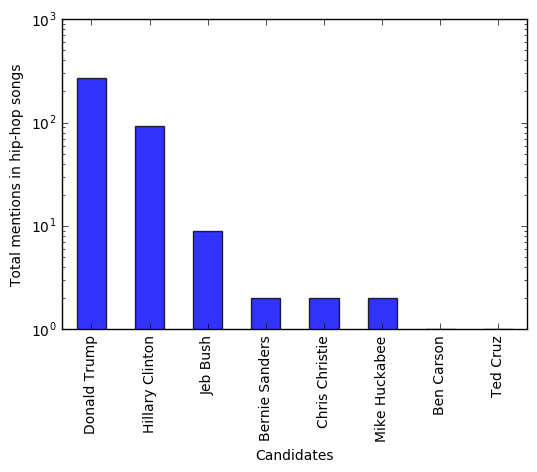

In [4]:
# Get number of mentions for each candidate
ax = df['candidate'].value_counts().plot(kind="bar",logy=True, alpha=0.8)
ax.set_xlabel("Candidates")
ax.set_ylabel("Total mentions in hip-hop songs")

### Temporal analysis of every mention of 2016 primary candidates in hip-hop songs

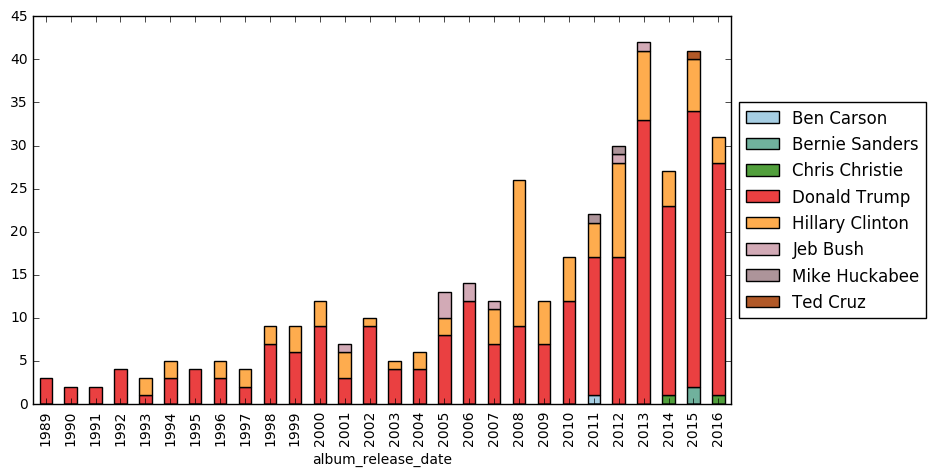

In [5]:
df.groupby(['album_release_date', 'candidate']).size().unstack().plot(kind='bar', stacked=True, colormap='Paired', figsize=(9,5)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

Trump's prominence and longevity as a figure in hip-hop is staggering. He and his brand have been referenced in a total of 266 songs dating back to 1989.

## Sentiment analysis on lyrics -comparing multiple sentiment lexicons
To see whether the hip-hop narratives around the candidates were changing in the run-up to the 2016 election, the dataset includes sentiment annotations for every reference as positive, negative or neutral. First, let's test how well different sentiment lexicons work on hip-hop lyrics taking the human annotations as ground truth.

In [6]:
from nltk.corpus import opinion_lexicon

In [7]:
opinion_lexicon.positive()

[u'a+', u'abound', u'abounds', u'abundance', ...]

In [8]:
opinion_lexicon.negative()

[u'2-faced', u'2-faces', u'abnormal', u'abolish', ...]

In [9]:
#White space tokenize
df.loc[4]['line'].split(' ')

['What',
 'you',
 'heard',
 'before',
 "ain't",
 'as',
 'big',
 'of',
 'a',
 'lesson',
 '/',
 'As',
 'George',
 'and',
 'Jeb',
 'Bush',
 'rigging',
 'elections']

In [10]:
# white space tokenization seems to work fine. Function call to the intersection of tokens and opinion lexicon
def count_words_sets(text,lex_list):
    assert(type(lex_list) == list)
    tokens = set([token.lower() for token in text.split(' ')])
    return [len(tokens.intersection(lex)) for lex in lex_list]

In [11]:
neg_set = set(opinion_lexicon.negative())
pos_set = set(opinion_lexicon.positive())

In [12]:
counts = [count_words_sets(text,[pos_set,neg_set]) for text in df['line']]

In [13]:
df = df.assign(pos_words = [count[0] for count in counts])
df = df.assign(neg_words = [count[1] for count in counts])

In [14]:
df.head()

,candidate,song,artist,sentiment,theme,album_release_date,line,url,pos_words,neg_words
id,,,,,,,,,,
1,Mike Huckabee,None Shall Pass,Aesop Rock,neutral,NaN,2011,"Wither by the watering hole, Border patrol / W...",http://genius.com/Aesop-rock-none-shall-pass-l...,0,0
2,Mike Huckabee,Wellstone,Soul Khan,negative,NaN,2012,Might find the door but never touch the key / ...,http://genius.com/Soul-khan-wellstone-lyrics,1,1
3,Jeb Bush,Awe,Dez & Nobs,neutral,NaN,2006,I heard Jeb Bush looking for a (inaudible),http://genius.com/Dez-and-nobs-awe-lyrics,0,0
4,Jeb Bush,The Truth,Diabolic,negative,political,2006,What you heard before ain't as big of a lesson...,http://genius.com/Diabolic-the-truth-lyrics,0,0
5,Jeb Bush,Money Man,Gorilla Zoe,negative,personal,2007,I'm comin back from Florida / Wit Jeb Bush and...,http://genius.com/Gorilla-zoe-money-man-lyrics,0,0


In [15]:
preds = []
for index,row in df.iterrows():
    if row['pos_words'] < row['neg_words']:
        preds.append('negative')
    elif row['pos_words'] > row['neg_words']:
        preds.append('positive')
    else:
        preds.append('neutral')
df['predicted_sentiment'] = preds
#df.head()

Classifier performance -

In [16]:
#Baseline performance by majority class
df['sentiment'].value_counts()

positive    178
neutral     128
negative     71
Name: sentiment, dtype: int64

Baseline accuracy by predicting majority class would be 178/377 = 0.472

In [17]:
acc=(df['predicted_sentiment']==df['sentiment']).mean()
print('Accuracy on nltk opinion lexicon: %.4f'%acc)

Accuracy on nltk opinion lexicon: 0.5385


Let's try a domain specific sentiment lexicon. SocialSent at Stanford University provides Community-specific sentiment lexicons for the 250 largest subreddit communities from reddit.com. We pick the sentiment lexicon for r/Music which is a subreddit dedicated to discussions on music. Lexicon available at: https://nlp.stanford.edu/projects/socialsent/

In [18]:
music_senti_lexicon = pd.read_csv('Music.tsv',sep='\t',header=None,names=['token','meansenti','stdsenti'])
music_senti_lexicon.head()

,token,meansenti,stdsenti
0,nickleback,-5.93,1.08
1,dislike,-5.87,0.83
2,creed,-5.75,1.07
3,nickelback,-5.54,1.07
4,hating,-5.48,1.26


In [19]:
#function to label sentiment based on word counts
def label_domain_sentiment(row):
    if row['meansenti'] < 0:
        return 'negative'
    elif row['meansenti'] > 0:
        return 'positive'

In [20]:
music_senti_lexicon['senti'] = music_senti_lexicon.apply (lambda row: label_domain_sentiment (row),axis=1)
music_senti_lexicon.head()
music_senti_lexicon['senti'].value_counts()

positive    2711
negative    2240
Name: senti, dtype: int64

In [21]:
positive_lexicon = set(music_senti_lexicon.loc[music_senti_lexicon['senti']=='positive']['token'])
negative_lexicon = set(music_senti_lexicon.loc[music_senti_lexicon['senti']=='negative']['token'])
len(positive_lexicon), len(negative_lexicon)

(2711, 2240)

In [22]:
counts1 = [count_words_sets(text,[positive_lexicon,negative_lexicon]) for text in df['line']]

In [23]:
df = df.assign(pos_words_music = [count[0] for count in counts1])
df = df.assign(neg_words_music = [count[1] for count in counts1])
#df.head()

In [24]:
preds_music = []
for index,row in df.iterrows():
    if row['pos_words_music'] < row['neg_words_music']:
        preds_music.append('negative')
    elif row['pos_words_music'] > row['neg_words_music']:
        preds_music.append('positive')
    else:
        preds_music.append('neutral')
df['predicted_sentiment_music'] = preds_music

In [25]:
df.head()

,candidate,song,artist,sentiment,theme,album_release_date,line,url,pos_words,neg_words,predicted_sentiment,pos_words_music,neg_words_music,predicted_sentiment_music
id,,,,,,,,,,,,,,
1,Mike Huckabee,None Shall Pass,Aesop Rock,neutral,NaN,2011,"Wither by the watering hole, Border patrol / W...",http://genius.com/Aesop-rock-none-shall-pass-l...,0,0,neutral,2,2,neutral
2,Mike Huckabee,Wellstone,Soul Khan,negative,NaN,2012,Might find the door but never touch the key / ...,http://genius.com/Soul-khan-wellstone-lyrics,1,1,neutral,2,7,negative
3,Jeb Bush,Awe,Dez & Nobs,neutral,NaN,2006,I heard Jeb Bush looking for a (inaudible),http://genius.com/Dez-and-nobs-awe-lyrics,0,0,neutral,0,3,negative
4,Jeb Bush,The Truth,Diabolic,negative,political,2006,What you heard before ain't as big of a lesson...,http://genius.com/Diabolic-the-truth-lyrics,0,0,neutral,3,5,negative
5,Jeb Bush,Money Man,Gorilla Zoe,negative,personal,2007,I'm comin back from Florida / Wit Jeb Bush and...,http://genius.com/Gorilla-zoe-money-man-lyrics,0,0,neutral,5,2,positive


In [26]:
acc=(df['predicted_sentiment_music']==df['sentiment']).mean()
print('Accuracy on r/music sentiment lexicon: %.4f'%acc)

Accuracy on r/music sentiment lexicon: 0.2971


Domain specific sentiment lexicon is performing much worse. Why? The lines from lyrics seem to be have more general english tokens. Whereas, the r/music lexicon has very specific tokens, trained on discussions on music. It performs poorly when applied to a different domain, here - hip-hop lyrics.

## Candidate mentions, by sentiment over time

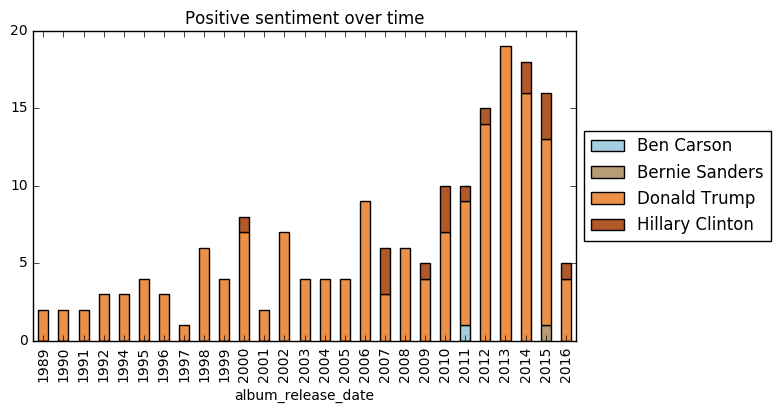

In [27]:
sentiment_over_time = df.groupby(['album_release_date', 'sentiment','candidate']).size().reset_index(name='mentions')
posdf = sentiment_over_time[sentiment_over_time.sentiment == 'positive']
posdf.pivot_table(index='album_release_date', columns='candidate', values='mentions', aggfunc='sum').plot.bar(rot=90, stacked=True,colormap='Paired',figsize=(7,4)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Positive sentiment over time')

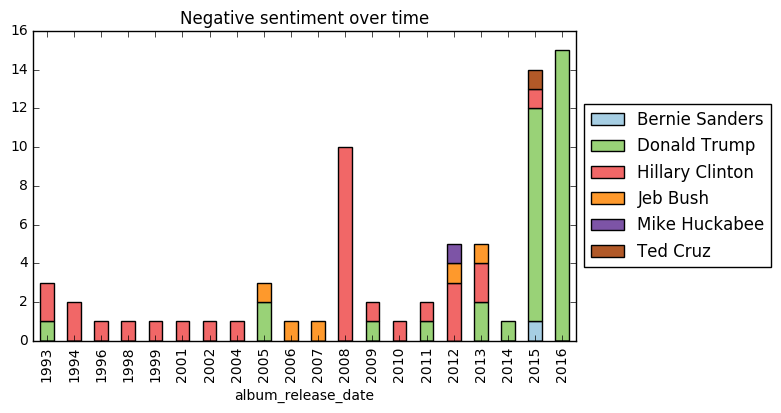

In [28]:
negdf = sentiment_over_time[sentiment_over_time.sentiment == 'negative']
negdf.pivot_table(index='album_release_date', columns='candidate', values='mentions', aggfunc='sum').plot.bar(rot=90, stacked=True,colormap='Paired',figsize=(7,4)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Negative sentiment over time')

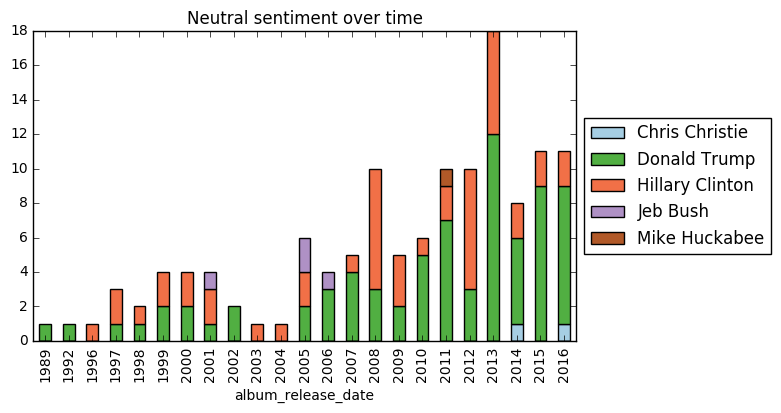

In [29]:
neudf = sentiment_over_time[sentiment_over_time.sentiment == 'neutral']
neudf.pivot_table(index='album_release_date', columns='candidate', values='mentions', aggfunc='sum').plot.bar(rot=90, stacked=True,colormap='Paired',figsize=(7,4)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Neutral sentiment over time')

Things start to look a little different for Trump in 2015. Before 2015, Trump had received only eight negative references in total; over the last year and a half, however, that number almost quadrupled in 2015. This is a reflection of a chance in his public persona from being a business tycoon to a politician (now making controversial statements around race, immigration etc). Hillary has a sweeping negative sentiment in 2008, from all the hip-hop lyrics during that year. This could be a reflection of the racial politics associated with her during the 2008 elections. Let's see if the polarity of mentions in hip-hop songs are predictive of presidency of the candidate.

In [30]:
#Adding column for candidates who won the presidency
elected_presidents =  ['Donald Trump']
def label_president(row):
    if row['candidate'] == 'Donald Trump':
        return 1
    else:
        return 0
sentiment_over_time['presidency'] = sentiment_over_time.apply (lambda row: label_president (row),axis=1)
sentiment_over_time.head(10)

,album_release_date,sentiment,candidate,mentions,presidency
0,1989,neutral,Donald Trump,1,1
1,1989,positive,Donald Trump,2,1
2,1990,positive,Donald Trump,2,1
3,1991,positive,Donald Trump,2,1
4,1992,neutral,Donald Trump,1,1
5,1992,positive,Donald Trump,3,1
6,1993,negative,Donald Trump,1,1
7,1993,negative,Hillary Clinton,2,0
8,1994,negative,Hillary Clinton,2,0
9,1994,positive,Donald Trump,3,1


In [31]:
import statsmodels.formula.api as sm
result = sm.ols(formula= 'presidency ~ album_release_date',data=sentiment_over_time).fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
==================================================================
Model:               OLS              Adj. R-squared:     0.028   
Dependent Variable:  presidency       AIC:                165.1265
Date:                2017-09-22 16:33 BIC:                170.5989
No. Observations:    114              Log-Likelihood:     -80.563 
Df Model:            1                F-statistic:        4.217   
Df Residuals:        112              Prob (F-statistic): 0.0423  
R-squared:           0.036            Scale:              0.24493 
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          26.4633  12.6518  2.0917 0.0387  1.3954 51.5311
album_release_date -0.0130   0.0063 -2.0535 0.0423 -0.0254 -0.0005
------------------------------------------------------------------
Omnibus:              0.164        Durbin-Watson:           3.021 
Prob(Omnibus):        0.921        Jarque-Bera (JB):        16.445
Skew:                 0.088        Prob(JB):                0.000 
Kurtosis:             1.148        Condition No.:           547575
==================================================================
* The condition number is large (5e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

Although the p-value looks statistically significant, p < alpha (0.05) the R^2 is bad. The model is not a good fit over hip hop album releases but seems better than chance. 

In [32]:
result = sm.ols(formula= 'presidency ~ C(sentiment) + mentions',data=sentiment_over_time).fit()
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.224   
Dependent Variable:   presidency        AIC:                 141.3849
Date:                 2017-09-22 16:33  BIC:                 152.3297
No. Observations:     114               Log-Likelihood:      -66.692 
Df Model:             3                 F-statistic:         11.86   
Df Residuals:         110               Prob (F-statistic):  8.62e-07
R-squared:            0.244             Scale:               0.19552 
---------------------------------------------------------------------
                         Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept                0.1422   0.0842 1.6885 0.0942 -0.0247 0.3090
C(sentiment)[T.neutral]  0.1583   0.1034 1.5309 0.1287 -0.0466 0.3633
C(sentiment)[T.positive] 0.3313   0.1109 2.9866 0.0035  0.1115 0.5512
mentions                 0.0506   0.0122 4.1429 0.0001  0.0264 0.0748
---------------------------------------------------------------------
Omnibus:               61.241         Durbin-Watson:            2.502
Prob(Omnibus):         0.000          Jarque-Bera (JB):         9.311
Skew:                  0.289          Prob(JB):                 0.010
Kurtosis:              1.725          Condition No.:            18   
=====================================================================

"""

This model has a much better $R^2$ and the coefficients are more interpretable. The p-values for positive polarity and mentions are significant at $p < 0.05$. The coefficients for positive polarity weigh higher towards a presidency.

## Candidate mentions - Themes/Subjects over time

In [33]:
subject_over_time = df.groupby(['album_release_date', 'theme','candidate']).size().reset_index(name='mentions')
subject_over_time.theme.values

array(['money', 'money', 'money', 'money', 'personal', 'personal',
       'political', 'political', 'money', 'personal', 'sexual', 'money',
       'personal', 'hotel', 'money', 'money', 'political', 'money',
       'personal', 'hotel', 'money', 'personal', 'political', 'hotel',
       'money', 'personal', 'personal', 'political', 'hotel', 'money',
       'personal', 'personal', 'hotel', 'money', 'personal', 'hotel',
       'money', 'personal', 'hotel', 'money', 'hotel', 'money', 'personal',
       'political', 'The Apprentice', 'hotel', 'money', 'personal',
       'personal', 'political', 'The Apprentice', 'hotel', 'money',
       'personal', 'political', 'The Apprentice', 'hotel', 'money',
       'personal', 'personal', 'The Apprentice', 'hotel', 'money',
       'personal', 'personal', 'political', 'hotel', 'money', 'personal',
       'political', 'political', 'The Apprentice', 'hotel', 'money',
       'money', 'personal', 'political', 'The Apprentice', 'hotel',
       'money', 'perso

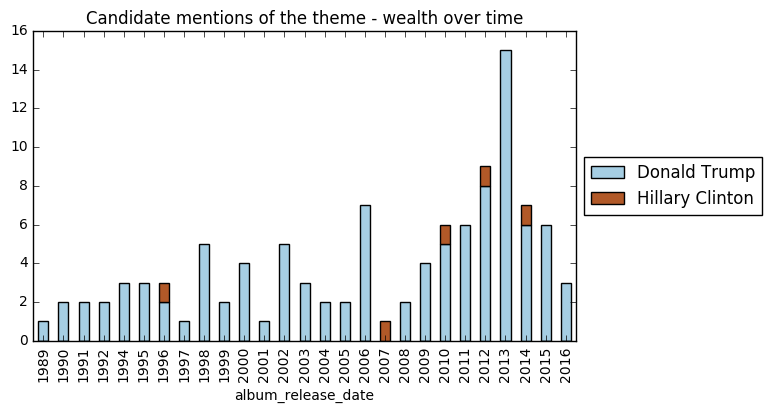

In [34]:
wealthdf = subject_over_time[subject_over_time.theme == 'money']
wealthdf.pivot_table(index='album_release_date', columns='candidate', values='mentions', aggfunc='sum').plot.bar(rot=90, stacked=True,colormap='Paired',figsize=(7,4)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Candidate mentions of the theme - wealth over time")

As seen above, Donald Trump's persona as a business tycoon has strongly contributed to the hip-hop narrative around him.

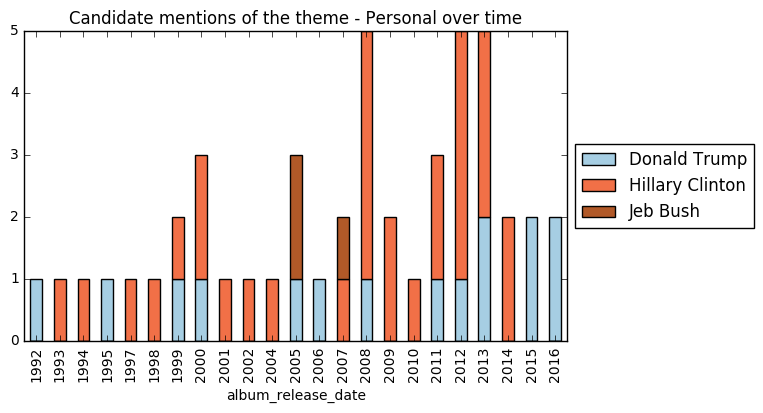

In [35]:
personaldf = subject_over_time[subject_over_time.theme == 'personal']
personaldf.pivot_table(index='album_release_date', columns='candidate', values='mentions', aggfunc='sum').plot.bar(rot=90, stacked=True,colormap='Paired',figsize=(7,4)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Candidate mentions of the theme - Personal over time")

Similar to the sentiment over time, the hip-hop narrative around Hillary Clinton in 2008 seems largely around her personal life. Overall, the mentions of personal themes in the lyrics are highest for Clinton than any other candidate.

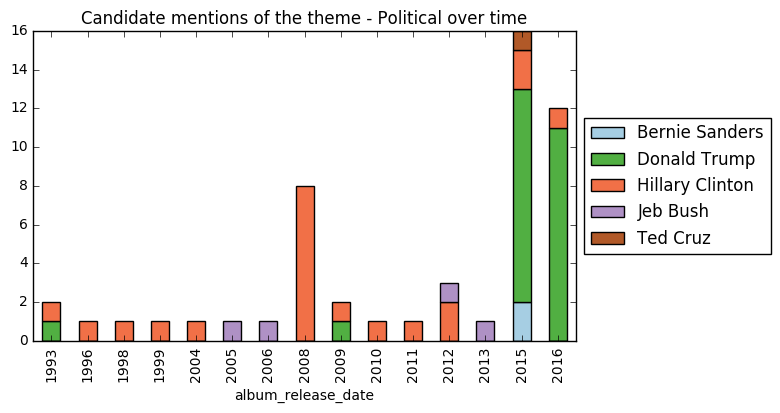

In [36]:
politicsdf = subject_over_time[subject_over_time.theme == 'political']
politicsdf.pivot_table(index='album_release_date', columns='candidate', values='mentions', aggfunc='sum').plot.bar(rot=90, stacked=True,colormap='Paired',figsize=(7,4)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Candidate mentions of the theme - Political over time")

Before 2015, there seem to be no political themes in the hip-hop narrative around Donald Trump. 
Let's check if the themes around candidate mentions in hip-hop lyrics are a predictor of presidency.

In [37]:
subject_over_time['presidency'] = subject_over_time.apply (lambda row: label_president (row),axis=1)
subject_over_time.head()

,album_release_date,theme,candidate,mentions,presidency
0,1989,money,Donald Trump,1,1
1,1990,money,Donald Trump,2,1
2,1991,money,Donald Trump,2,1
3,1992,money,Donald Trump,2,1
4,1992,personal,Donald Trump,1,1


In [38]:
result1 = sm.ols(formula='presidency ~ C(theme) + mentions + album_release_date', data=subject_over_time).fit()
result1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:                OLS               Adj. R-squared:      0.448   
Dependent Variable:   presidency        AIC:                 104.7055
Date:                 2017-09-22 16:34  BIC:                 129.7929
No. Observations:     120               Log-Likelihood:      -43.353 
Df Model:             8                 F-statistic:         13.09   
Df Residuals:         111               Prob (F-statistic):  3.69e-13
R-squared:            0.485             Scale:               0.13037 
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             13.5576  10.4483  1.2976 0.1971 -7.1464 34.2616
C(theme)[T.hotel]     -0.0971   0.1448 -0.6706 0.5039 -0.3840  0.1898
C(theme)[T.money]     -0.2792   0.1409 -1.9822 0.0499 -0.5583 -0.0001
C(theme)[T.personal]  -0.6316   0.1336 -4.7260 0.0000 -0.8965 -0.3668
C(theme)[T.political] -0.8592   0.1389 -6.1870 0.0000 -1.1344 -0.5840
C(theme)[T.power]      0.0584   0.2809  0.2081 0.8355 -0.4981  0.6150
C(theme)[T.sexual]    -0.7246   0.2140 -3.3862 0.0010 -1.1486 -0.3006
mentions               0.0463   0.0160  2.9044 0.0044  0.0147  0.0779
album_release_date    -0.0063   0.0052 -1.2086 0.2294 -0.0166  0.0040
---------------------------------------------------------------------
Omnibus:               3.107         Durbin-Watson:            2.243 
Prob(Omnibus):         0.211         Jarque-Bera (JB):         2.834 
Skew:                  0.376         Prob(JB):                 0.242 
Kurtosis:              3.026         Condition No.:            635913
=====================================================================
* The condition number is large (6e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

This appears to be a much better model. The $R^2$, F-statistic and $P(f-stat) << 0.01$. The p-values for money and sexual themes in hip-hop lyrics appear to be statistically significant. Let's check the correlation of residuals.

In [39]:
from scipy.stats import spearmanr, pearsonr
spearmanr(subject_over_time['presidency'],result1.resid)

SpearmanrResult(correlation=0.81222060273457408, pvalue=2.1539648297858562e-29)

correlation = 0.82 Strong evidence of correlated errors. This means that the IID assumption is likely violated, so our $p$-values are overconfident.

Statistically speaking then, hip-hop lyrics have no connection to the presidency. Next steps-  check correlated errors.